## Simply average long period analysis
---

In [176]:
import numpy as np
import pandas as pd
from scripts import StockPriceDatabase

report = pd.read_csv("../database/reportData/Quarterly_Value.csv", index_col=[0])
report["Date"] = report["Date"].astype('datetime64[s]')
spd = StockPriceDatabase("../database/stockPrice/")
wig = pd.read_csv("../database/designData/WIGs.csv")

In [177]:
M_DAY_DISTANCE = 30

In [178]:
class StockPriceAnalyzer:
    @staticmethod
    def rate_of_return(stock_price: pd.DataFrame, 
                       date: np.datetime64,
                       value_type: str = "Close"):
        pass

    def avg_rate_of_return(stock_price: pd.DataFrame,
                           date: np.datetime64,
                           value_type: str = "Close"):
        pass

    def avg_stock_price(stock_price: pd.DataFrame,
                        date_begin: np.datetime64,
                        date_end: np.datetime64,
                        value_type: str = "Close"):
        
        pass

In [179]:
benchmarking_value = pd.DataFrame()

for idx, row in report.iterrows():
    date, ticker = row["Date"], row["Ticker"]
    # Company
    stock_price = spd.get_stock_price(row["Ticker"])
    stock_price.index = stock_price.index.astype('datetime64[s]')
    close_avg_earlier = stock_price[np.all([stock_price.index > row["Date"] + np.timedelta64(-2*M_DAY_DISTANCE, 'D'),
                                            stock_price.index < row["Date"] + np.timedelta64(-1*M_DAY_DISTANCE, 'D')], axis=0)]["Close"].mean()
    close_avg_after   = stock_price[np.all([stock_price.index > row["Date"] + np.timedelta64(1*M_DAY_DISTANCE, 'D'),
                                            stock_price.index < row["Date"] + np.timedelta64(2*M_DAY_DISTANCE, 'D')], axis=0)]["Close"].mean()
    company_growth_index = (close_avg_after - close_avg_earlier) / close_avg_earlier * 100
    
    # WIGs
    try:
        wig_ticker = np.where(wig.to_numpy() == row["Ticker"])[1][0]
    except:
        break
    stock_price = spd.get_stock_price(wig.columns[wig_ticker])
    stock_price.index = stock_price.index.astype('datetime64[s]')
    close_avg_earlier = stock_price[np.all([stock_price.index > row["Date"] + np.timedelta64(-2*M_DAY_DISTANCE, 'D'),
                                            stock_price.index < row["Date"] + np.timedelta64(-1*M_DAY_DISTANCE, 'D')], axis=0)]["Close"].mean()
    close_avg_after   = stock_price[np.all([stock_price.index > row["Date"] + np.timedelta64(1*M_DAY_DISTANCE, 'D'),
                                            stock_price.index < row["Date"] + np.timedelta64(2*M_DAY_DISTANCE, 'D')], axis=0)]["Close"].mean()
    wig_growth_index = (close_avg_after - close_avg_earlier) / close_avg_earlier * 100

    benchmarking_against_index = company_growth_index - wig_growth_index
    
    if np.isnan(benchmarking_against_index):
        continue

    benchmarking_value = pd.concat([benchmarking_value, pd.DataFrame(data=[benchmarking_against_index], index=[idx], columns=["BenchmarkRanking"])])

In [180]:
from scripts import ReportIndexConverter

report_index = ReportIndexConverter.castReportToIndexes(report)

In [191]:
prepared_data = pd.concat([report_index, benchmarking_value], axis=1, join="inner")
prepared_data = prepared_data.drop(columns=["Date", "Ticker"])
mean = prepared_data["BenchmarkRanking"].mean()
std  = prepared_data["BenchmarkRanking"].std()
prepared_data = prepared_data[~np.any([prepared_data["BenchmarkRanking"] > mean + 3*std,
                                       prepared_data["BenchmarkRanking"] < mean - 3*std], axis = 0)]
mean = prepared_data["BenchmarkRanking"].mean()
std  = prepared_data["BenchmarkRanking"].std()
prepared_data["BenchmarkRanking"] = pd.cut(prepared_data["BenchmarkRanking"], bins=[-np.inf, mean-std, mean+std, np.inf], labels=[-1, 0, 1])
prepared_data = prepared_data[prepared_data["BenchmarkRanking"]!=0]
prepared_data.replace([np.inf, -np.inf], np.nan, inplace=True)
prepared_data = prepared_data.dropna()

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [190]:
prepared_data.isin(np.inf)

TypeError: only list-like or dict-like objects are allowed to be passed to DataFrame.isin(), you passed a 'float'

In [184]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

y = prepared_data["BenchmarkRanking"]
X = prepared_data.drop(columns=["BenchmarkRanking"]).to_numpy()

In [185]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2)

In [186]:
np.unique(y_train, return_counts=True)

(array([-1,  1]), array([635, 602]))

In [187]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=4, n_jobs=-1)
clf.fit(X_train, y_train)

ValueError: Input X contains infinity or a value too large for dtype('float32').

ACC = 0.7713498622589532


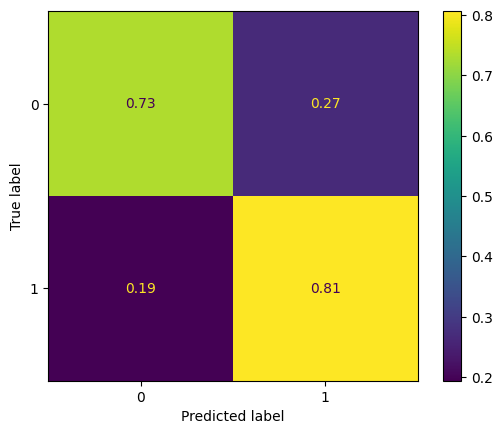

In [171]:
from sklearn import metrics 
y_pred = clf.predict(X_train)

# Jakość klasyfikacji
acc = metrics.accuracy_score(y_train, y_pred)

# Macierz pomyłek
cm = metrics.confusion_matrix(y_train, y_pred, labels=clf.classes_, normalize='true')

print(f"ACC = {acc}")
disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

ACC = 0.7032967032967034


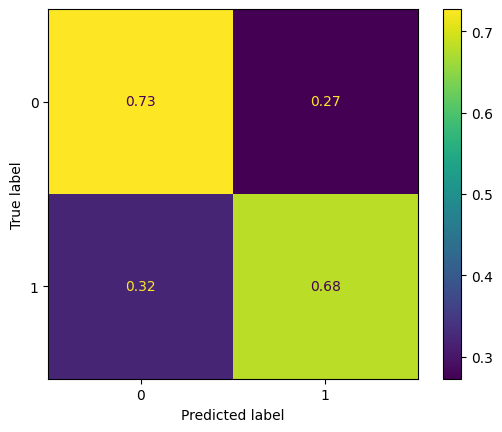

In [172]:
from sklearn import metrics 
y_pred = clf.predict(X_test)

# Jakość klasyfikacji
acc = metrics.accuracy_score(y_test, y_pred)

# Macierz pomyłek
cm = metrics.confusion_matrix(y_test, y_pred, labels=clf.classes_, normalize='true')

print(f"ACC = {acc}")
disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()